In [1]:
import sys
import os
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import sklearn
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch
import itertools
import qinfer as qi
import matplotlib as mpl
from matplotlib.ticker import PercentFormatter

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from lfig import LatexFigure

sys.path.append("/home/bf16951/QMD")
import qmla

%matplotlib inline

run_path = "Dec_18/20_12"
results_dir = "/home/bf16951/bc_results/"
# results = qmla.load_results(
#     results_folder = results_dir,
#     results_time = run_path,
# )
# q = results['qmla_instance']
# es = results['exploration_strategy']
# storage = results['storage']

# gene_pool = es.genetic_algorithm.gene_pool
# gene_pool.sort_values('f_score', inplace=True, ascending=False)
# model_f_scores = q.model_f_scores
# f_score_cmap = es.f_score_cmap
f_score_cmap = plt.cm.RdBu

In [2]:
ga_summary = pd.DataFrame()
unique_chromosomes = pd.DataFrame()

for run_path in ["Dec_17/21_46", "Dec_18/20_12"]:

    run_unique_chromosomes = pd.read_pickle(
        os.path.join(
            "/home/bf16951/bc_results/", 
            run_path,
            'combined_datasets', 
            'unique_chromosomes.p'
        )
    )
    run_ga_summary = pd.read_pickle(
        os.path.join(
            results_dir, run_path, 'combined_datasets', 'gen_alg_summary.p'
    ))
    run_unique_chromosomes["run"] = run_path
    run_ga_summary["run"] = run_path
    
    
    ga_summary = ga_summary.append(
        run_ga_summary, ignore_index=True, 
    )
    unique_chromosomes = unique_chromosomes.append(
        run_unique_chromosomes, ignore_index=True
    )

# 2 random instances to remove so there's exactly 100 reported
drop_indices = np.random.choice(ga_summary.index, 2, replace=False)
removed_instances = ga_summary.iloc[drop_indices][
    ["run", "qmla_id"]
]

ga_summary.drop(drop_indices, inplace=True)

# also remove their chromosomes
for di in drop_indices:
    r = removed_instances.loc[di].run
    qid = removed_instances.loc[di].qmla_id
    
    chromsomes_to_remove = unique_chromosomes[
        (unique_chromosomes.qmla_id == qid)
        & ( unique_chromosomes.run == r)
    ].index
    
    unique_chromosomes.drop(
        chromsomes_to_remove, inplace=True
    )


In [3]:
found_terms = qmla.utilities.flatten(list(ga_summary.champ_terms.values))
unique_terms = list(set(found_terms))
term_counts = {a : found_terms.count(a) for a in unique_terms}

non_gene_weight = max(term_counts.values())/10
present_colour = mpl.colors.to_hex(f_score_cmap(0.9)) # colour for true terms
non_present_colour = mpl.colors.to_hex(f_score_cmap(0.1)) #  colour for false positive terms
non_gene_colour = 'k'

true_info = pickle.load(open(
    os.path.join(
        results_dir, 
        run_path,
        'run_info.p'
    ),
    'rb'
))
true_terms = true_info['true_model'].split('+')

In [4]:
term_occurences = pd.DataFrame()

max_n_qubits = 4
pauli_axes = ['x', 'y', 'z']
avail_qubits = range(1, max_n_qubits+1)

for q1 in avail_qubits:
    for q2 in avail_qubits:
        for p in pauli_axes:
            term = 'pauliSet_{q1}J{q2}_{p}J{p}_d4'.format(
                q1 = q1, 
                q2 = q2, 
                p = p
            )
            try:
                ct = term_counts[term]
                colour = present_colour
                if term not in true_terms: 
#                     ct *= -1
                    colour = non_present_colour
            except:
                ct = 0
            if q1>=q2: 
                colour = non_gene_colour
                ct = non_gene_weight
                
            if q2 > 1 and q1 < max_n_qubits:
                this_term = pd.Series({
                    'p' : p , 
                    'q1' : q1, 
                    'q2' : q2, 
                    'count' : ct,
                    'colour' : colour
                })
                term_occurences = term_occurences.append(
                    this_term, 
                    ignore_index = True
                )
            
term_types = list(itertools.product(avail_qubits[1:], pauli_axes))

piv = term_occurences.pivot_table(
    columns='q1', 
    index = ['q2', 'p'],
    values='count'
)
terms_matrix = np.matrix(piv)

colours_matrix = np.matrix(term_occurences.pivot_table(
    columns='q1',
    index=['q2', 'p'],
    values='colour', 
    aggfunc=lambda x: ''.join(str(v) for v in x)
))

In [5]:
# Hinton diagram

def terms_hinton(ax, matrix, colours_matrix):
    max_weight = None
    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))

#     ax.set_aspect('equal', 'box')

    for (x, y), w in np.ndenumerate(matrix):
    #     color = present_colour if w > 0 else non_present_colour
        color = colours_matrix[x, y]

        size = np.sqrt( np.abs(w) / max_weight)
        # normalise size so they appear as squares
        size = np.sqrt(np.abs(w) / max_weight)
        size *= 0.618
        size_x = size
        size_y = 1.618*size
        rect = plt.Rectangle(
            [x - size_x / 2, y - size_y / 2], 
            size_x, 
            size_y,
            facecolor=color, 
            edgecolor=color
        )

        if color == non_gene_colour:
            nsizex = 0.35
            nsizey = 1.618*nsizex
            
            rect = plt.Rectangle(
                [x - nsizex/2, 
                 y - nsizey/2], 
                nsizex, 
                nsizey,
                facecolor=color, 
                edgecolor=color
            )


        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()
    ax.set_xticks(range(-1, matrix.shape[0]))
    # xlabels = [r"${p}_{{{q}}}$".format(q=t[1], p=t[0]) for t in term_types]
    # xlabels = [r"${p}/{q}$".format(q=t[1], p=t[0]) for t in term_types]
    xlabels = [r"$ \hat{{\sigma}}_{{i,{p}}}^{{{q}}}$".format(q=t[1], p=t[0]) for t in term_types]
    xlabels.insert(0, '')
    ax.set_xticklabels(xlabels)
    ax.set_yticks(range(matrix.shape[1]))
    ax.set_ylabel('Qubit, i', labelpad=10)
    ax.set_xlabel('Coupling qubit/axis', labelpad=10)

    ax.set_yticks(
        range(matrix.shape[1]), 
    )
    ax.set_yticklabels(
        list(range(1, 1+matrix.shape[1]))
    )
    ax.tick_params(axis=u'both', which=u'both',length=0, pad=10)


    legend_elements = [
        Patch(
            facecolor=present_colour, 
            label=r"$\in \mathcal{T}_0$"
        ),
        Patch(
            facecolor=non_present_colour, 
            label=r"$\notin \mathcal{T}_0$"
        ),
        Patch(
            facecolor=non_gene_colour, 
            label=r"$\notin \mathcal{T}$"
        ),
    ]
    ax.legend(
        handles=legend_elements,
        ncol=len(legend_elements), 
    #     loc='lower left'
        loc='lower center',
    #     bbox_to_anchor=(0.1, 1.02)
    )

    ylim = ax.get_ylim()
    ax.set_ylim(
        matrix.shape[1] + 0.5, 
        ylim[1] - 0.25
    )
    for x in range(matrix.shape[1]):
        ax.axhline(x, color='grey', lw=0.5, )
    for y in range(matrix.shape[0]):
        ax.axvline(y, color='grey', lw=0.5)

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


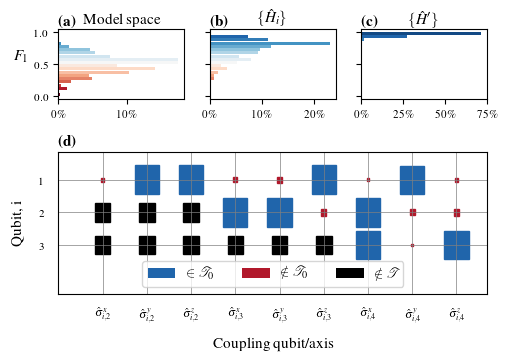

In [6]:

fscore_cmap = mpl.cm.RdBu # q.growth_class.f_score_cmap
f_score_bins = list(np.arange(0, 1.01, 0.05))
bin_colours = [fscore_cmap(b) for b in f_score_bins] # or set to fixed colour for all

sampled_f_scores = pickle.load(open('sampled_f_scores.p', 'rb'))  
regenerate_f_samples = False
if regenerate_f_samples:
    # sampled_f_scores = [rand_model_f(true_chromosome, n_terms) for _ in range(int(n_runs))]
    sampled_f_scores = [
        rand_model_f(true_chromosome, n_terms, i) 
        for i in range(2**n_terms - 1)
    ] # checking every model since

    pickle.dump(
        sampled_f_scores, 
        open(
            'sampled_f_scores.p', 
            'wb'
        )
    )


lf = LatexFigure(
    fraction=0.8,
    use_gridspec=True,
    gridspec_layout = (2,3),
    gridspec_params = {
        'height_ratios' : [1,2],
        'hspace' : 0.5, 
    }
)

# Model space
ax = lf.new_axis()
hist, bin_edges = np.histogram(
    sampled_f_scores, 
    bins = f_score_bins, 
    weights=np.ones(len(sampled_f_scores)) / len(sampled_f_scores),
)
ax.barh(
    bin_edges[:-1], 
    hist, 
    align='edge', 
    height=1/len(bin_edges),
    color=bin_colours,
)
fticks = [0, 0.25, 0.5, 0.75,  1]
fticks = [0, 0.5, 1]
ax.set_yticks(fticks)
ax.set_ylabel(r"$F_{1}$", rotation=360, labelpad=10)
ax.xaxis.set_major_formatter(PercentFormatter(1, decimals=0))
ax.set_xlabel("Model space", )
ax.xaxis.set_label_position('top')

# QMLA found models
ax = lf.new_axis()
generated_f_scores = list(unique_chromosomes.f_score.values)

hist, bin_edges = np.histogram(
    generated_f_scores,
    bins = f_score_bins,
    weights=np.ones(len(generated_f_scores)) / len(generated_f_scores),
)
ax.barh(
    bin_edges[:-1], 
    hist, 
    align='edge', 
    height=1/len(bin_edges),
    color=bin_colours,
)

ax.set_yticks(fticks)
ax.tick_params(
    labelleft=False
)
ax.set_ylabel('')
ax.xaxis.set_major_formatter(PercentFormatter(1, decimals=0))
# ax.set_xlabel(r"$\{ \hat{H}_i \}$", labelpad=10)
ax.set_xlabel(r"$\{\hat{H}_i\}$")
ax.xaxis.set_label_position('top')

# Champion models
ax = lf.new_axis()
f_scores = ga_summary['champ_f_score']

hist, bin_edges = np.histogram(
    f_scores,
    bins = f_score_bins,
    weights=np.ones(len(f_scores)) / len(f_scores),
)

ax.barh(
    bin_edges[:-1], 
    hist, 
    align='edge', 
    height=1/len(bin_edges),
    color=bin_colours,
)

ax.set_yticks(fticks)
ax.tick_params(
    labelleft=False
)
ax.set_ylabel('')

ax.set_xticks([0, 0.25, 0.50, 0.75])
ax.xaxis.set_major_formatter(PercentFormatter(1, decimals=0))
ax.set_xlabel(r"$\{ \hat{H}^{\prime} \}$")
ax.xaxis.set_label_position('top')


ax = lf.new_axis(
    span=(1,3)
)
terms_hinton(ax, terms_matrix, colours_matrix)

lf.save(
    os.path.join(
        "..", "theoretical_study", "figures", 
        "gen_alg_run.pdf"
    )
    
)

In [7]:
qmla_f_median = np.median(generated_f_scores)
qmla_f_std = np.std(generated_f_scores)
print("Generated models f: median={} std={}".format(
    np.round(qmla_f_median, 2), 
    np.round(qmla_f_std, 2)
))

sampled_f_median = np.median(sampled_f_scores)
sampled_f_std = np.std(sampled_f_scores)
print("Generated models f: median={} std={}".format(
    np.round(sampled_f_median, 2), 
    np.round(sampled_f_std, 2)
))

print("There are {} unique chromosomes across {} instances => average={}".format(
    len(unique_chromosomes),
    len(ga_summary), 
    int(len(unique_chromosomes) / len(ga_summary)),
    
))

print("Precise success rate: {}%".format(100*ga_summary.true_found.mean()))
print("Minimum champ f score: {}".format(
    ga_summary.champ_f_score.min()
))

Generated models f: median=0.76 std=0.15
Generated models f: median=0.5 std=0.14
There are 43123 unique chromosomes across 100 instances => average=431
Precise success rate: 71.0%
Minimum champ f score: 0.8888888888888888


In [8]:
chrom_counts = []
for q in unique_chromosomes.qmla_id.unique():
    for r in unique_chromosomes.run.unique():
        n_chrom = len(unique_chromosomes[
            (unique_chromosomes.run == r)
            & (unique_chromosomes.qmla_id == q)
        ])
        if n_chrom > 0:
            chrom_counts.append(n_chrom)
            
print("num chromosomes per instance - median={}, std = {}".format(
    np.median(chrom_counts),
    np.std(chrom_counts),    
))

num chromosomes per instance - median=429.0, std = 45.91380075750645


In [161]:
scipy.special.comb(60, 2)

1770.0